In [1]:
import mido
import midi_io

from PIL import Image, ImageFilter, ImageOps

import numpy as np

import matplotlib.pyplot as plt

In [2]:
from contour import get_contours, sort_contours, show_contours
from oscilloscope import OscilloscopeDrawer

# Read the Image

In [3]:
img = Image.open("Images/mauzy.png")
img = img.convert("L") # Convert to grayscale

## Image pre-processing
Do some pre-processing to bring out the features we want most.

In [4]:
# Edge Detection
# img = img.filter(ImageFilter.FIND_EDGES)

In [5]:
# Invert Image
img = ImageOps.invert(img)

In [6]:
img_data = np.asarray(img)

In [7]:
# Remove outer edge (first & last col/row)
# img_data = img_data[1:-1, 1:-1]

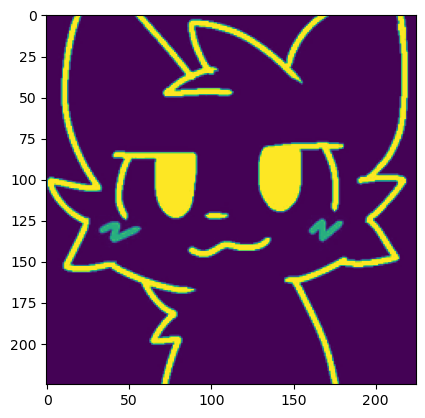

In [8]:
plt.imshow(img_data)

# Extract Contours from Image

In [9]:
contours = get_contours(img_data, threshold=200)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

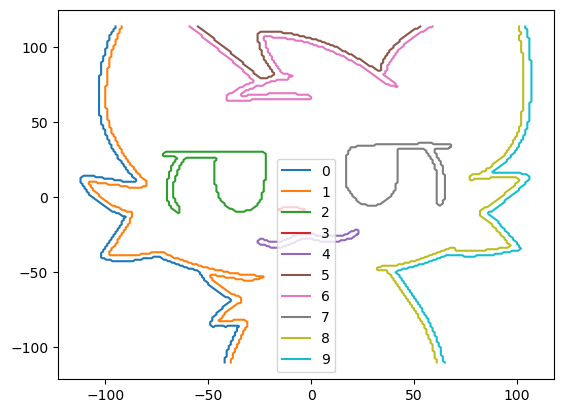

In [10]:
show_contours(contours, legend=True)

# Read the Midi File

In [11]:
mid = mido.MidiFile('Samples/eek_reworked.mid')

In [12]:
tempo = midi_io.get_tempo(mid.tracks[-1])
time_sig = midi_io.get_time_sig(mid.tracks[-1])

bpm = mido.tempo2bpm(tempo, time_sig)

In [22]:
durations_1, freqs_1 = midi_io.track_to_freqs(mid.tracks[0], bpm, mid.ticks_per_beat, ignore_rests=True)
durations_2, freqs_2 = midi_io.track_to_freqs(mid.tracks[1], bpm, mid.ticks_per_beat, ignore_rests=True)

In [23]:
# I'm taking the frequencies for this song down a few measures because it is quite high
freqs_1 = np.array(freqs_1)/4
freqs_2 = np.array(freqs_2)/2

# Oscilloscope Drawing

In [24]:
# Oscilloscope parameters
rate = 500000 # Samples per second
data_type = np.int16

save_path = 'Samples'

In [25]:
drawer = OscilloscopeDrawer(img_data.shape, rate=rate, data_type=data_type, save_path=save_path)

## Create Oscilloscope Drawing

In [26]:
x, y = np.array([]), np.array([])

for duration, freq in zip(durations_1, freqs_1):
    if freq == 0:
        x = np.append(x, np.zeros(int(duration*rate)))
        y = np.append(y, np.zeros(int(duration*rate)))
        continue
    
    # Create oscilloscope drawing
    x_drawing, y_drawing = drawer.play_drawing(freq, contours)
    
    # Concatenate oscilloscope drawings for duration
    num_frames = int(duration*rate)
    num_drawings = int(num_frames/x_drawing.size)+1
    
    x_drawing = np.concatenate([x_drawing]*num_drawings)[:num_frames]
    y_drawing = np.concatenate([y_drawing]*num_drawings)[:num_frames]
    
    x = np.append(x, x_drawing)
    y = np.append(y, y_drawing)

## Create Square Wave Track

In [27]:
square_wave = drawer.play_square_wave(durations_2, freqs_2)

## The Final Oscilloscope Drawing

In [28]:
length = max(x.size, square_wave.size)

In [29]:
# Pad arrays with 0s at the end so that they are all of equal length
x_pad = np.pad(x, (0,length-x.size))
y_pad = np.pad(y, (0,length-y.size))
square_wave_pad = np.pad(square_wave, (0,length-square_wave.size))

In [30]:
drawer.write_wav(x_pad/2 + square_wave_pad, y_pad/2 + square_wave_pad, 'midi_image')